In [24]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet101, ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import trange, tqdm
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Load image dataset

In [15]:
def create_dataset(img_folder):
   
    train_data=[]
    val_data=[]
    test_data=[]
    
    train_label=[]
    val_label=[]
    test_label=[]
   
    for dir1 in tqdm(os.listdir(img_folder)):
        for eye in os.listdir(os.path.join(img_folder, dir1)):
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [0, 1, 3, 5, 7, 9]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                train_data.append(img)
                train_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [2, 8]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                val_data.append(img)
                val_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [4, 6]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                test_data.append(img)
                test_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
    return np.array(train_data), np.array(train_label), np.array(val_data), np.array(val_label), np.array(test_data), np.array(test_label)

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = create_dataset('CASIA-Iris-Thousand')

  0%|          | 0/1000 [00:00<?, ?it/s]

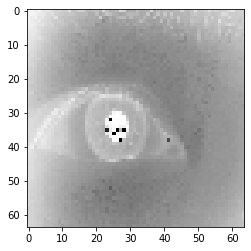

In [17]:
plt.imshow((X_train[0]*255).astype(np.uint8))

## Save the image dataset

In [18]:
np.save('temp_data/X_train.npy', X_train)
np.save('temp_data/X_val.npy', X_val)
np.save('temp_data/X_test.npy', X_test)

np.save('temp_data/y_train.npy', y_train)
np.save('temp_data/y_val.npy', y_val)
np.save('temp_data/y_test.npy', y_test)

In [65]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [66]:
def combine_LR(X, y, classes, img_num):
    X_combined = []
    y_combined = []
    for i in range(0, classes*img_num*2, img_num*2):
        for j in range(img_num):
            X_combined.append(np.concatenate((X[i+j], X[i+j+img_num]), axis=1))
            y_combined.append("".join([*y[i]][:3]))
    return np.array(X_combined), np.array(y_combined)

In [67]:
X_train, y_train = combine_LR(X_train, y_train, 1000, 6)
X_val, y_val = combine_LR(X_val, y_val, 1000, 2)
X_test, y_test = combine_LR(X_test, y_test, 1000, 2)

## Randomize the dataset

In [68]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

# Model using transfer learning only

## Preprocess the dataset

In [56]:
# X_train = resnet_preprocess_input(X_train)
# X_val = resnet_preprocess_input(X_val)
# X_test = resnet_preprocess_input(X_test)

X_train = vgg16_preprocess_input(X_train)
X_val = vgg16_preprocess_input(X_val)
X_test = vgg16_preprocess_input(X_test)

# X_train = inception_resnet_preprocess_input(X_train)
# X_val = inception_resnet_preprocess_input(X_val)
# X_test = inception_resnet_preprocess_input(X_test)

In [57]:
le = LabelEncoder()

y_train = to_categorical(le.fit_transform(y_train), num_classes=1000)
y_val = to_categorical(le.fit_transform(y_val), num_classes=1000)
y_test = to_categorical(le.fit_transform(y_test), num_classes=1000)

In [21]:
aug = ImageDataGenerator(
	zoom_range=0.05,
	height_shift_range=10,
	shear_range=0.15,
	rotation_range=10,
	fill_mode="nearest")

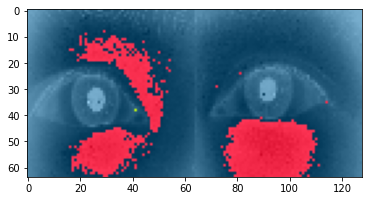

In [22]:
plt.imshow((X_train[0]*255).astype(np.uint8))

## Training Model

In [23]:
# Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
with tf.device('GPU:0'):
    # Load the ResNet101 model with pre-trained weights on ImageNet dataset
    model = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

    # Freeze the layers of the ResNet101 model
    for layer in model.layers:
        layer.trainable = False

    # Add custom layers on top of the ResNet101 model
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(1000, activation='softmax')(x)

    # Combine the ResNet101 model with the custom layers
    model = keras.models.Model(inputs=model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    # history = model.fit(aug.flow(X_train, y_train, batch_size=16), epochs=40, 
    #                     steps_per_epoch=len(X_train) // 16, 
    #                     validation_data=(X_val, y_val), verbose=1)
    history = model.fit(X_train, y_train, batch_size=16, epochs=40,
                        steps_per_epoch=len(X_train) // 16, 
                        validation_data=(X_val, y_val), verbose=1)

Epoch 1/40
375/375 [==============================] - 9s 21ms/step - loss: 6.1721 - accuracy: 0.0390 - val_loss: 4.2112 - val_accuracy: 0.2435
Epoch 2/40
375/375 [==============================] - 8s 20ms/step - loss: 3.7174 - accuracy: 0.2688 - val_loss: 2.4759 - val_accuracy: 0.4740
Epoch 3/40
375/375 [==============================] - 8s 20ms/step - loss: 2.0395 - accuracy: 0.5537 - val_loss: 1.4984 - val_accuracy: 0.6720
Epoch 4/40
375/375 [==============================] - 8s 20ms/step - loss: 1.1777 - accuracy: 0.7220 - val_loss: 1.1956 - val_accuracy: 0.7230
Epoch 5/40
375/375 [==============================] - 8s 20ms/step - loss: 0.7127 - accuracy: 0.8350 - val_loss: 1.0364 - val_accuracy: 0.7690
Epoch 6/40
375/375 [==============================] - 7s 20ms/step - loss: 0.5110 - accuracy: 0.8755 - val_loss: 0.9936 - val_accuracy: 0.7625
Epoch 7/40
375/375 [==============================] - 7s 20ms/step - loss: 0.4411 - accuracy: 0.8843 - val_loss: 0.8903 - val_accuracy: 0.8005

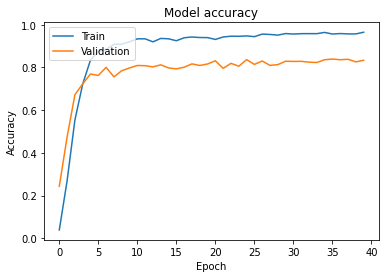

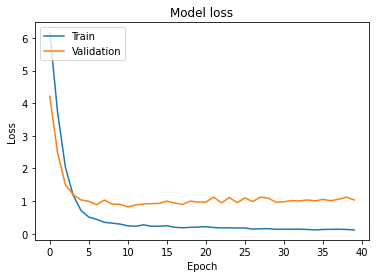

In [26]:
# Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Save model

In [27]:
model.save('Model/VGG16_40.h5')

In [44]:
model = keras.models.load_model('Model/VGG16_40.h5')

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

## Test the prediction

In [58]:
# Predict on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy Score: {accuracy * 100:.2f}%')


63/63 [==============================] - 2s 25ms/step
Accuracy Score: 81.70%


In [31]:
import seaborn as sns

In [32]:
# plt.figure(figsize=(9,9))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = f'Accuracy Score: {accuracy * 100:.2f}%'
# plt.title(all_sample_title, size = 15);

In [33]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       0.40      1.00      0.57         2
           7       1.00      0.50      0.67         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.50      0.50      0.50         2
          13       1.00      0.50      0.67         2
          14       0.67      1.00      0.80         2
          15       0.67      1.00      0.80         2
          16       1.00      1.00      1.00         2
          17       1.00    

c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Model using transfer learning and SVM

In [7]:
import sklearn.svm as svm
import sklearn.model_selection as model_selection

In [35]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [70]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

In [71]:
with tf.device('GPU:0'):
    features_train = model.predict(X_train)
    features_val = model.predict(X_val)
    features_test = model.predict(X_test)

63/63 [==============================] - 2s 38ms/step


In [72]:
clf = svm.SVC(kernel='linear', C=1.0, probability=True)
clf.fit(features_train.reshape(features_train.shape[0], -1), y_train)

SVC(kernel='linear', probability=True)

In [73]:
import pickle

In [74]:
filename = 'Model/svm_VGG16.pickle'

In [75]:
# pickle.dump(clf, open(filename, 'wb'))

In [76]:
clf = pickle.load(open(filename, "rb"))

In [77]:
y_predict = clf.predict(features_val.reshape(features_val.shape[0], -1))

In [78]:
accuracy = accuracy_score(y_predict, y_val)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 90.15%


In [79]:
y_predict = clf.predict(features_test.reshape(features_test.shape[0], -1))

In [80]:
accuracy = accuracy_score(y_predict, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 90.55%


In [81]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_predict)

In [82]:
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,...,900,901,902,903,904,905,906,907,908,909
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
